In [57]:
#Installation Cell
!pip install -q torch torchvision
!pip install -q opencv-python matplotlib numpy Pillow
!pip install -q 'git+https://github.com/facebookresearch/segment-anything-2.git'
!pip install -q transformers
!pip install -q supervision

# Import required libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import supervision as sv
from transformers import pipeline

print("All packages installed successfully!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6 requires iopath<0.1.10,>=0.1.7, but you have iopath 0.1.10 which is incompatible.
All packages installed successfully!


In [58]:
#SAM 2 Setup
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Download SAM 2 model checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

# Initialize SAM 2 model
model_config = "sam2_hiera_l.yaml"
checkpoint = "sam2_hiera_large.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam2_model = build_sam2(model_config, checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

print(f"SAM 2 model loaded on {device}")

SAM 2 model loaded on cuda


In [59]:
#Text-to-Mask Pipeline Setup
class TextToMaskPipeline:
    def __init__(self, device="cuda"):
        self.device = device
        # Use a zero-shot object detection model
        self.detector = pipeline(
            "zero-shot-object-detection",
            model="google/owlvit-base-patch32",
            device=0 if device == "cuda" else -1
        )

    def text_to_bounding_box(self, image, text_prompt, threshold=0.1):
        """
        Convert text prompt to bounding boxes using zero-shot detection
        """
        # Convert PIL image to RGB if needed
        if isinstance(image, np.ndarray):
            image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            image_pil = image.convert('RGB')

        # Run detection
        detections = self.detector(image_pil, candidate_labels=[text_prompt])

        # Filter by confidence threshold
        boxes = []
        scores = []
        for detection in detections:
            if detection['score'] >= threshold:
                box = detection['box']
                # Convert to [x1, y1, x2, y2] format
                x1, y1, width, height = box['xmin'], box['ymin'], box['xmax'] - box['xmin'], box['ymax'] - box['ymin']
                boxes.append([x1, y1, x1 + width, y1 + height])
                scores.append(detection['score'])

        return np.array(boxes), np.array(scores)

# Initialize the pipeline
text_pipeline = TextToMaskPipeline(device=device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [60]:
#Utility Functions
def load_image_from_url(url):
    """Load image from URL"""
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return np.array(image)

def load_image_from_path(path):
    """Load image from local path"""
    image = Image.open(path)
    return np.array(image)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*',
               s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*',
               s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [64]:
# @title Main Segmentation Function (Fixed)
def text_driven_segmentation(image, text_prompt, confidence_threshold=0.2):
    """
    Perform text-driven segmentation on an image

    Args:
        image: numpy array or PIL Image
        text_prompt: string describing the object to segment
        confidence_threshold: confidence threshold for object detection

    Returns:
        masks: list of segmentation masks
        boxes: list of bounding boxes
        image_with_overlay: image with mask overlay
    """

    # Convert to numpy array if needed
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image.copy()

    # Set image for predictor
    predictor.set_image(image_np)

    # Get bounding boxes from text prompt
    boxes, scores = text_pipeline.text_to_bounding_box(
        image_np, text_prompt, threshold=confidence_threshold
    )

    print(f"Found {len(boxes)} detection(s) for '{text_prompt}'")

    all_masks = []
    all_boxes = []

    # Process each detected box
    for i, box in enumerate(boxes):
        print(f"Processing detection {i+1} with confidence {scores[i]:.3f}")

        # Convert box to SAM 2 format
        input_box = np.array(box)

        # Predict mask
        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=True,
        )

        # Select the best mask
        best_mask_idx = np.argmax(scores)
        best_mask = masks[best_mask_idx]

        all_masks.append(best_mask)
        all_boxes.append(box)

    # Create overlay visualization - FIXED VERSION
    image_with_overlay = image_np.copy()

    for mask in all_masks:
        # Ensure mask is boolean
        if mask.dtype != bool:
            mask = mask.astype(bool)

        color = np.array([30, 144, 255])  # Blue color

        # Apply mask overlay correctly
        for c in range(3):  # For each color channel
            image_with_overlay[mask, c] = (
                image_with_overlay[mask, c] * 0.5 + color[c] * 0.5
            )

    return all_masks, all_boxes, image_with_overlay

Loading sample image...
Processing image with text prompt: 'dog'
Found 1 detection(s) for 'dog'
Processing detection 1 with confidence 0.176


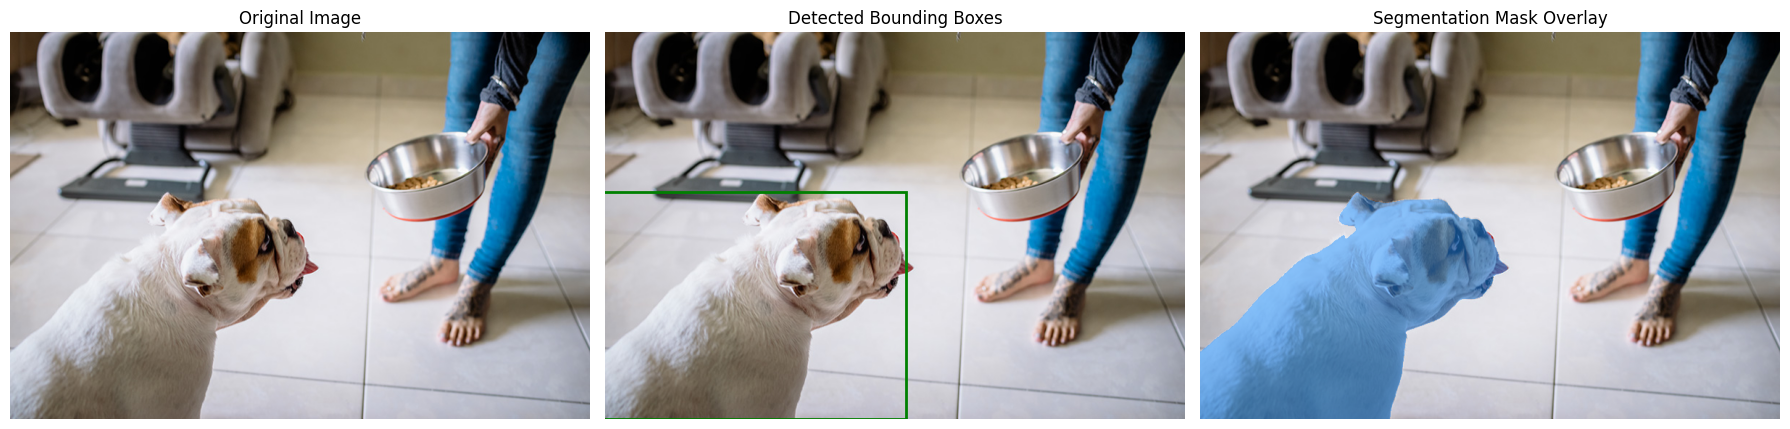

Segmentation completed! Found 1 object(s).


In [65]:
# @title Demo with Sample Image
# @markdown Run this cell to test the pipeline with a sample image

# Load a sample image
sample_url = "https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg"
print("Loading sample image...")
image = load_image_from_url(sample_url)

# Text prompt
text_prompt = "dog"  # @param {type:"string"}
confidence_threshold = 0.1  # @param {type:"slider", min:0.0, max:1.0, step:0.05}

print(f"Processing image with text prompt: '{text_prompt}'")

# Perform segmentation
masks, boxes, result_image = text_driven_segmentation(
    image, text_prompt, confidence_threshold
)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Image with bounding boxes
axes[1].imshow(image)
for box in boxes:
    show_box(box, axes[1])
axes[1].set_title('Detected Bounding Boxes')
axes[1].axis('off')

# Image with mask overlay
axes[2].imshow(result_image)
axes[2].set_title('Segmentation Mask Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Segmentation completed! Found {len(masks)} object(s).")

In [66]:
# @title Custom Image Upload and Processing
# @markdown Upload your own image and specify a text prompt

from google.colab import files
import io

# Upload image
uploaded = files.upload()

if uploaded:
    # Get the first uploaded file
    file_name = list(uploaded.keys())[0]
    image = load_image_from_path(file_name)

    # Text prompt input
    custom_prompt = "person"  # @param {type:"string"}
    custom_confidence = 0.1  # @param {type:"slider", min:0.0, max:1.0, step:0.05}

    print(f"Processing uploaded image with text prompt: '{custom_prompt}'")

    # Perform segmentation
    masks, boxes, result_image = text_driven_segmentation(
        image, custom_prompt, custom_confidence
    )

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Image with bounding boxes
    axes[1].imshow(image)
    for box in boxes:
        show_box(box, axes[1])
    axes[1].set_title('Detected Bounding Boxes')
    axes[1].axis('off')

    # Image with mask overlay
    axes[2].imshow(result_image)
    axes[2].set_title('Segmentation Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Segmentation completed! Found {len(masks)} object(s).")
else:
    print("No image uploaded. Please run the cell again to upload an image.")

No image uploaded. Please run the cell again to upload an image.


Performing multi-object segmentation...
Processing: person
Processing: dog
Processing: car
Applying 1 mask(s) for 'person' with color [255   0   0]
  Mask shape: (534, 800), True pixels: 49220
Applying 1 mask(s) for 'dog' with color [  0 255   0]
  Mask shape: (534, 800), True pixels: 77083
Applying 0 mask(s) for 'car' with color [  0   0 255]


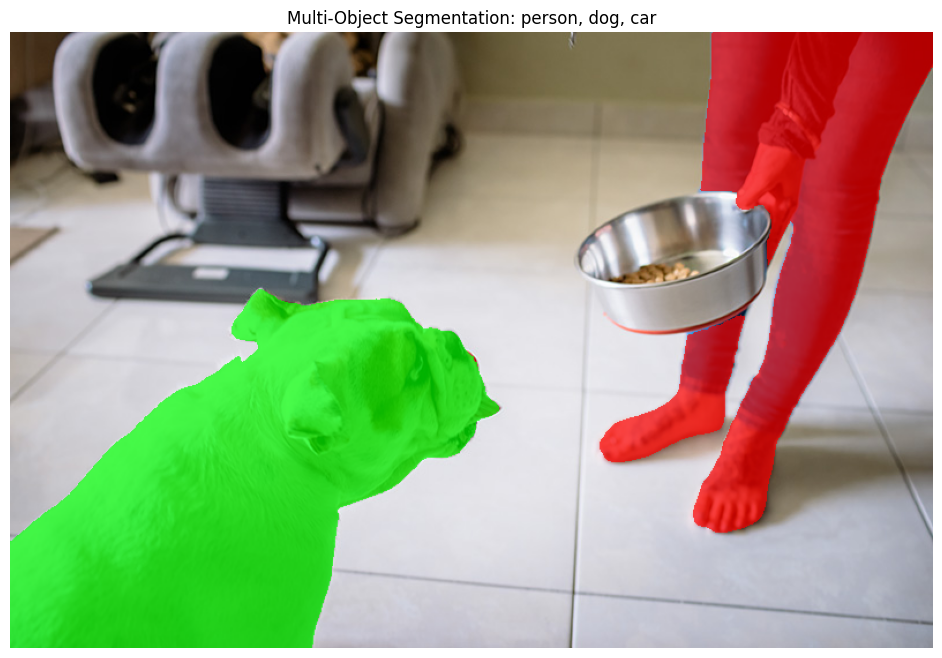

Found 1 person(s)
Found 1 dog(s)
Found 0 car(s)


In [68]:
# @title Fixed: Multiple Object Detection
# @markdown Try detecting multiple objects with different text prompts

def multi_object_segmentation_fixed(image, text_prompts, confidence_threshold=0.1):
    """
    Segment multiple objects specified by different text prompts - FIXED VERSION
    """
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image.copy()

    predictor.set_image(image_np)

    all_results = {}

    for prompt in text_prompts:
        print(f"Processing: {prompt}")
        boxes, scores = text_pipeline.text_to_bounding_box(
            image_np, prompt, threshold=confidence_threshold
        )

        prompt_masks = []
        for box in boxes:
            input_box = np.array(box)
            masks, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True,
            )
            best_mask_idx = np.argmax(scores)
            prompt_masks.append(masks[best_mask_idx])

        all_results[prompt] = {
            'masks': prompt_masks,
            'boxes': boxes,
            'count': len(prompt_masks)
        }

    return all_results

def apply_masks_to_image_fixed(image, all_results):
    """Apply multiple masks to image with different colors - FIXED VERSION"""
    image_np = image.copy() if isinstance(image, np.ndarray) else np.array(image)
    result_image_multi = image_np.copy().astype(np.float32)

    colors = {
        "person": [255, 0, 0],    # Red
        "dog": [0, 255, 0],      # Green
        "cat": [0, 255, 255],    # Yellow
        "car": [0, 0, 255],      # Blue
        "bird": [255, 0, 255],   # Magenta
        "chair": [255, 165, 0],  # Orange
    }

    for prompt, result in all_results.items():
        color = np.array(colors.get(prompt, [255, 255, 0]))  # Default to yellow
        print(f"Applying {len(result['masks'])} mask(s) for '{prompt}' with color {color}")

        for mask in result['masks']:
            # Ensure mask is boolean
            if mask.dtype != bool:
                boolean_mask = mask.astype(bool)
            else:
                boolean_mask = mask

            print(f"  Mask shape: {boolean_mask.shape}, True pixels: {np.sum(boolean_mask)}")

            # Apply color to masked regions
            for c in range(3):
                result_image_multi[boolean_mask, c] = (
                    result_image_multi[boolean_mask, c] * 0.3 +
                    color[c] * 0.7
                )

    # Convert back to uint8
    result_image_multi = np.clip(result_image_multi, 0, 255).astype(np.uint8)
    return result_image_multi

# Example with multiple objects
multi_prompts = ["person", "dog", "car"]  # @param
multi_confidence = 0.1  # @param {type:"slider", min:0.0, max:1.0, step:0.05}

print("Performing multi-object segmentation...")
multi_results = multi_object_segmentation_fixed(image, multi_prompts, multi_confidence)

# Apply masks with fixed function
result_image_multi = apply_masks_to_image_fixed(image, multi_results)

# Display results
plt.figure(figsize=(12, 8))
plt.imshow(result_image_multi)
plt.title(f'Multi-Object Segmentation: {", ".join(multi_prompts)}')
plt.axis('off')
plt.show()

# Print results summary
for prompt, result in multi_results.items():
    print(f"Found {result['count']} {prompt}(s)")